In [1]:
# IMPORTS
import mne
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [61]:
def epoching(raw, events, tmin, tmax, event_id=dict, reject_criterion:dict=None):
    '''
    Epochs raw data based on events and event_id. Rejects epochs based on reject_criterion if specified.

    Args:
        raw (mne.io.Raw): raw data
        events (numpy array): events
        tmin (float): start of epoch in seconds
        tmax (float): end of epoch in seconds
        event_id (dict): dictionary of events
        reject_criterion (dict): dictionary of reject criterion

    Returns:
        epochs (mne.Epochs): epoched data
    '''

    if reject_criterion:
        epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax,
                    baseline=(None, 0), reject=reject_criterion, preload=True,
                    proj=True) # have proj = True if you want to reject 

    else: 
        epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax,
                    baseline=(None, 0), reject=reject_criterion, preload=True,
                    proj=False)
    
    epochs.pick_types(meg=True, eog=False, ias=False, emg=False, misc=False,
                        stim=False, syst=False)

    # apply projections
    epochs.apply_proj()

    return epochs 

In [62]:
# PREPROCESSING FUNCTIONS
def preprocess_sensor_space_data(subject, date, raw_path,
                                 h_freq=40,
                                 tmin=-0.200, tmax=1.000, baseline=(None, 0),
                                 reject=None, decim=4, reject_criterion=None):
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    epochs_list = list()
    for recording_index, recording_name in enumerate(recording_names):
        fif_fname = recording_name[4:]
        full_path = join(raw_path, subject, date, 'MEG', recording_name,
                         'files', fif_fname + '.fif')
        print(full_path)
        raw = mne.io.read_raw(full_path, preload=True)
        
        raw.filter(l_freq=None, h_freq=h_freq, n_jobs=3)
        
        events = mne.find_events(raw, min_duration=0.002)
        if 'self' in recording_name:
            event_id = dict(self_positive=11, self_negative=12,
                            button_press=23)
        elif 'other' in recording_name: 
            event_id = dict(other_positive=21, other_negative=22,
                            button_press=23)
        else:
            raise NameError('Event codes are not coded for file')
        
        # added a epoching function which includes a reject criterion that was not present in OG script
        epochs = epoching(raw, events, tmin=tmin, tmax=tmax,
                          event_id=event_id, reject_criterion=reject_criterion)
        
        epochs_list.append(epochs)
        
        if recording_index == 0:
            X = epochs.get_data()
            y = epochs.events[:, 2]
        else:
            X = np.concatenate((X, epochs.get_data()), axis=0)
            y = np.concatenate((y, epochs.events[:, 2]))
    
    return epochs_list


def preprocess_source_space_data(subject, date, raw_path, subjects_dir,
                                 epochs_list,
                              method='MNE', lambda2=1, pick_ori='normal',
                              label=None):
    if epochs_list is None:
        epochs_list = preprocess_sensor_space_data(subject, date, raw_path,
                                                   return_epochs=True)
    y = np.zeros(0)
    for epochs in epochs_list: # get y
        y = np.concatenate((y, epochs.events[:, 2]))
    
    if label is not None:
        label_path = join(subjects_dir, subject, 'label', label)
        label = mne.read_label(label_path)
        
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    for epochs_index, epochs in enumerate(epochs_list): ## get X
        
        fwd_fname = recording_names[epochs_index][4:] + '-oct-6-src-' + \
                    '5120-fwd.fif'
        fwd = mne.read_forward_solution(join(subjects_dir,
                                             subject, 'bem', fwd_fname))
        noise_cov = mne.compute_covariance(epochs, tmax=0.000)
        inv = mne.minimum_norm.make_inverse_operator(epochs.info,
                                                     fwd, noise_cov)
  
        stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2,
                                                     method, label,
                                                     pick_ori=pick_ori)
        for stc_index, stc in enumerate(stcs):
            this_data = stc.data
            if epochs_index == 0 and stc_index == 0:
                n_trials = len(stcs)
                n_vertices, n_samples = this_data.shape
                this_X = np.zeros(shape=(n_trials, n_vertices, n_samples))
            this_X[stc_index, :, :] = this_data
            
        if epochs_index == 0:
            X = this_X
        else:
            X = np.concatenate((X, this_X))
    return X, y

def get_X_and_y(epochs_list):
    for recording_index in range(len(epochs_list)):
        these_epochs = epochs_list[recording_index]
        if recording_index == 0:
            X = these_epochs.get_data()
            y = these_epochs.events[:, 2]
        else:
            X = np.concatenate((X, these_epochs.get_data()), axis=0)
            y = np.concatenate((y, these_epochs.events[:, 2]))
            
    return X, y

In [63]:
# DEFINE PATHS
import pathlib
path = pathlib.Path.cwd()

raw_path = path.parents[1] / "834761"
subjects_dir = path.parents[1] / "835482" 

In [64]:
# RUNNING FUNCTIONS
epochs_list = preprocess_sensor_space_data('0114', '20230927_000000',
        raw_path=raw_path,
        decim=10) ##CHANGE TO YOUR PATHS # don't go above decim=10

times = epochs_list[0].times # get time points for later

'''
X_source, y = preprocess_source_space_data('0114', '20230927_000000',
        raw_path=raw_path,
        subjects_dir=subjects_dir,
        epochs_list=epochs_list) ##CHANGE TO YOUR PATHS
'''

/work/834761/0114/20230927_000000/MEG/001.self_block1/files/self_block1.fif
Opening raw data file /work/834761/0114/20230927_000000/MEG/001.self_block1/files/self_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 156000 ... 540999 =    156.000 ...   540.999 secs
Ready.
Reading 0 ... 384999  =      0.000 ...   384.999 secs...


/tmp/ipykernel_1553/1435204013.py:15: RuntimeWarning: This filename (/work/834761/0114/20230927_000000/MEG/001.self_block1/files/self_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    1.4s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    4.3s finished


163 events found
Event IDs: [ 11  12  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 120 events and 1201 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...
/work/834761/0114/20230927_000000/MEG/002.other_block1/files/other_block1.fif
Opening raw data file /work/834761/0114/20230927_000000/MEG/002.other_block1/files/other_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 

/tmp/ipykernel_1553/1435204013.py:15: RuntimeWarning: This filename (/work/834761/0114/20230927_000000/MEG/002.other_block1/files/other_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.6s finished


163 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 120 events and 1201 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...
/work/834761/0114/20230927_000000/MEG/003.self_block2/files/self_block2.fif
Opening raw data file /work/834761/0114/20230927_000000/MEG/003.self_block2/files/self_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)

/tmp/ipykernel_1553/1435204013.py:15: RuntimeWarning: This filename (/work/834761/0114/20230927_000000/MEG/003.self_block2/files/self_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s


162 events found
Event IDs: [ 11  12  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.1s finished


Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 120 events and 1201 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...
/work/834761/0114/20230927_000000/MEG/004.other_block2/files/other_block2.fif
Opening raw data file /work/834761/0114/20230927_000000/MEG/004.other_block2/files/other_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
      

/tmp/ipykernel_1553/1435204013.py:15: RuntimeWarning: This filename (/work/834761/0114/20230927_000000/MEG/004.other_block2/files/other_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.3s finished


161 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 120 events and 1201 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...
/work/834761/0114/20230927_000000/MEG/005.self_block3/files/self_block3.fif
Opening raw data file /work/834761/0114/20230927_000000/MEG/005.self_block3/files/self_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)

/tmp/ipykernel_1553/1435204013.py:15: RuntimeWarning: This filename (/work/834761/0114/20230927_000000/MEG/005.self_block3/files/self_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.3s finished


165 events found
Event IDs: [ 11  12  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 120 events and 1201 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...
/work/834761/0114/20230927_000000/MEG/006.other_block3/files/other_block3.fif
Opening raw data file /work/834761/0114/20230927_000000/MEG/006.other_block3/files/other_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 

/tmp/ipykernel_1553/1435204013.py:15: RuntimeWarning: This filename (/work/834761/0114/20230927_000000/MEG/006.other_block3/files/other_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.7s


161 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 120 events and 1201 original time points ...


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    2.9s finished


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...


"\nX_source, y = preprocess_source_space_data('0114', '20230927_000000',\n        raw_path=raw_path,\n        subjects_dir=subjects_dir,\n        epochs_list=epochs_list) ##CHANGE TO YOUR PATHS\n"

In [65]:
X_sensor, y = get_X_and_y(epochs_list)

In [51]:
y_combined = combine_triggers(y, combine=[[11, 12], [21, 22]])

[11, 12]
[21, 22]


In [52]:
print(y_combined)

[1112 1112 1112 1112 1112   23 1112   23 1112   23   23 1112 1112   23
   23 1112 1112 1112 1112 1112 1112   23   23 1112 1112 1112 1112   23
 1112 1112 1112   23   23   23   23 1112 1112 1112   23 1112 1112 1112
 1112   23 1112   23 1112 1112 1112 1112 1112 1112   23   23 1112 1112
   23 1112   23   23 1112 1112   23 1112 1112   23   23   23 1112 1112
   23   23 1112   23 1112 1112 1112 1112   23   23 1112   23 1112 1112
   23 1112 1112   23   23 1112 1112   23 1112 1112 1112 1112 1112 1112
   23 1112 1112 1112   23 1112 1112 1112 1112 1112 1112   23 1112   23
 1112 1112 1112 1112   23 1112 1112 1112   23 2122 2122 2122   23 2122
 2122 2122   23 2122   23 2122 2122   23   23   23 2122   23   23   23
   23 2122 2122   23 2122 2122 2122 2122 2122 2122 2122 2122 2122   23
   23 2122 2122 2122   23 2122   23   23 2122 2122 2122 2122 2122   23
   23   23 2122   23 2122 2122 2122 2122 2122 2122   23   23 2122 2122
   23 2122 2122   23   23   23 2122   23 2122   23 2122 2122 2122 2122
   23 

In [53]:
print(y)

[12 12 12 11 12 23 11 23 11 23 23 11 12 23 23 11 12 12 12 12 11 23 23 11
 11 12 12 23 11 11 11 23 23 23 23 11 12 11 23 11 11 11 11 23 12 23 12 11
 12 11 12 12 23 23 11 12 23 12 23 23 11 11 23 12 12 23 23 23 12 12 23 23
 12 23 11 12 11 12 23 23 12 23 11 11 23 12 11 23 23 12 11 23 11 12 11 12
 12 12 23 12 11 11 23 12 12 11 12 12 11 23 11 23 11 11 12 12 23 11 11 11
 23 22 21 22 23 22 21 22 23 21 23 21 22 23 23 23 22 23 23 23 23 22 22 23
 22 22 21 21 21 21 21 22 21 23 23 21 21 22 23 21 23 23 22 22 22 21 22 23
 23 23 22 23 21 22 21 22 21 22 23 23 22 21 23 21 21 23 23 23 22 23 22 23
 22 21 22 21 23 23 21 23 21 23 21 21 22 22 21 22 22 23 22 21 22 22 23 22
 21 22 23 22 21 21 22 23 21 22 21 21 22 21 21 23 21 23 21 23 21 21 22 22
 11 12 11 11 23 11 23 23 23 12 23 23 12 12 12 12 23 12 12 11 12 11 11 11
 11 11 23 11 23 23 12 11 11 12 23 11 23 12 12 23 23 12 11 23 23 11 12 12
 12 23 11 11 12 11 23 12 11 11 11 11 23 23 23 23 12 12 12 11 12 11 12 12
 12 23 11 23 12 11 11 11 12 23 23 23 11 12 23 23 12

In [66]:
# SIMPLE CLASSIFICATION
def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

def balance_class_weights_multiple(X, y):
    """
    Balances the class weight by removing trials so each class has the same number of trials as the class with the least trials.

    Parameters
    ----------
    X : array
        Data array with shape (n_channels, n_trials, n_times)
    y : array
        Array with shape (n_trials, ) containing several classes

    Returns
    -------
    X_equal : array
        Data array with shape (n_channels, n_trials, n_times) with equal number of trials for each class
    y_equal : array
        Array with shape (n_trials, ) containing classes with equal number of trials for each class

    """
    keys, counts = np.unique(y, return_counts = True)

    keep_inds = []

    for key in keys:
        index = np.where(np.array(y) == key)
        random_choices = np.random.choice(index[0], size = counts.min(), replace=False)
        keep_inds.extend(random_choices)
    
    X_equal = X[keep_inds, :, :]
    y_equal = y[keep_inds]

    return X_equal, y_equal

def combine_triggers(y, combine):
    y_combined = y.copy()

    for pair in combine:
        print(pair)
        combine_pair = int(str(pair[0]) + str(pair[1]))
        for i, trigger in enumerate(y_combined):
            if trigger in pair:
                y_combined[i] = combine_pair
    
    return y_combined

def simple_classication(X, y, triggers, penalty='none', C=1.0, combine=None):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]

    # get indices for only the triggers we want
    indices = get_indices(y, triggers)

    # reduce data based on these indices
    X = X[indices,:,:]
    y = y[indices]
    
    # equalize
    X, y = balance_class_weights_multiple(X, y)

    if combine:
        y = combine_triggers(y, combine)

    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in tqdm(range(n_samples)):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):
    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()


In [10]:
#%% RUN FUNCTION
sensor_pos_neg_self = simple_classication(X_lh_V1,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

sensor_pos_self_response = simple_classication(X_sensor,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

#%% PLOT
plot_classfication(times, sensor_pos_neg_self,
                   title='positive-self vs. negative-self')

plot_classfication(times, sensor_pos_self_response,
                   title='positive-self vs. response')

NameError: name 'X_lh_V1' is not defined

In [67]:
# where Wernicke's ish is? I think
X_lh_wernicke, y = preprocess_source_space_data('0114', '20230927_000000',
        raw_path=raw_path,
        subjects_dir=subjects_dir,
        label='lh.supramarginal.label', epochs_list=epochs_list)
        ##CHANGE TO YOUR PATHS

# where Wernicke's ish is? I think
X_rh_wernicke, y = preprocess_source_space_data('0114', '20230927_000000',
        raw_path=raw_path,
        subjects_dir=subjects_dir,
        label='rh.supramarginal.label', epochs_list=epochs_list)
        ##CHANGE TO YOUR PATHS       

Reading forward solution from /work/835482/0114/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...


    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 7.6e-09 (2.2e-16 eps * 306 dim * 1.1e+05  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 24120
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rot

[11, 12]
[21, 22]


100%|██████████| 1201/1201 [08:58<00:00,  2.23it/s]


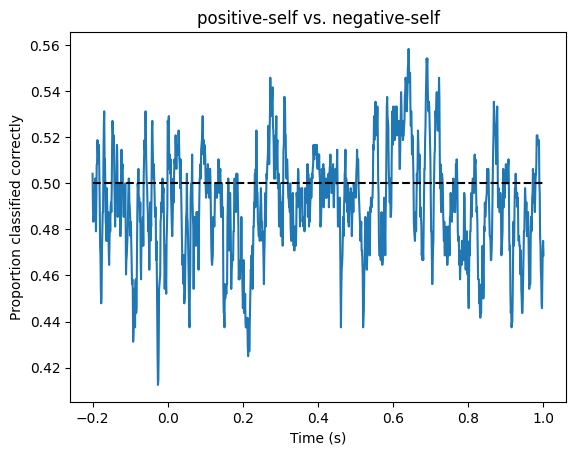

In [69]:
test_classification = simple_classication(X_rh_wernicke,
                                  y, triggers=[11, 12, 21, 22],
                                  penalty='l2', C=1e-3, combine=[[11,12], [21,22]])

#%% PLOT
plot_classfication(times, test_classification,
                   title='positive-self vs. negative-self')

In [60]:
test_classification = simple_classication(X_lh_wernicke,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

#%% PLOT
plot_classfication(times, test_classification,
                   title='positive-self vs. negative-self')

  1%|          | 23/2201 [00:02<04:39,  7.78it/s]


KeyboardInterrupt: 